In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

customers_df = pd.read_csv('Customers.csv')
customers_df.drop(columns=['Unnamed: 0'], inplace=True)

orders_df = pd.read_csv("Orders Table.csv")
orders_df.drop(columns=['Unnamed: 0'], inplace=True)
orders_df['Order Date'] = pd.to_datetime(orders_df['Order Date'], errors='coerce')

products_df = pd.read_csv("Products Table.csv")
products_df.drop(columns=['Unnamed: 0'], inplace=True)

# Feature engineering
These are the features that we are going to feature engineering

It is important to refer to this additional data dictionary because the name can be abit misleading since I can't make the feature name too long

1. ordered: 0 means customer has not made any orders before, 1 means yes but only on 1 day, 2 means yes and on >1 day
2. total_order: Total number of orders customer has ever made
3. ave_monthly_orders: Average number of orders per month between the earliest and latest order of that customer, for customers who has made orders on >1 days, 0 if otherwise
4. days_last_order: The number of days between the latest date the customer made an order and the last date of the dataset. NA if never made any orders
5. returned: 0 means the customer has never returned any orders before, 1 if otherwise
6. only_promo_order: 1 means the customer has only place order/s the promotional period, 0 if otherwise.
7. total spend: Total spending a customer has ever made 
8. ave_monthly_spending: Average spending per month between the earliest and latest order, for customers who has made orders on >1 days, 0 if otherwise
9. most_ordered_cat: The category of products that the customer ordered the most

In [3]:
# Create a copy of customers_df
customers_copy = customers_df.copy()

# Calculate the required new columns for each customer in customers_copy based on orders_df

# 1. ordered: 0 means customer has not made any orders before, 1 means yes but only on 1 day, 2 means yes and on >1 day
orders_per_day = orders_df.groupby('CustomerID')['Order Date'].nunique()
customers_copy['ordered'] = customers_copy['CustomerID'].map(lambda x: 2 if orders_per_day.get(x, 0) > 1 else (1 if orders_per_day.get(x, 0) == 1 else 0))


In [4]:
# 2. total_order: Total number of orders customer has ever made
total_orders = orders_df.groupby('CustomerID').size()
customers_copy['total_order'] = customers_copy['CustomerID'].map(total_orders).fillna(0).astype(int)

In [5]:
# 3. ave_monthly_orders: Average number of orders per month between the earliest and latest order of that customer
earliest_order = orders_df.groupby('CustomerID')['Order Date'].min()
latest_order = orders_df.groupby('CustomerID')['Order Date'].max()
tenure_months = (latest_order - earliest_order).dt.days / 30.44
ave_monthly_orders = total_orders / tenure_months
ave_monthly_orders[tenure_months < 1] = 0  # Setting 0 for customers with orders on <=1 day
customers_copy['ave_monthly_orders'] = customers_copy['CustomerID'].map(ave_monthly_orders).fillna(0)

In [6]:
# 4. days_last_order: The number of days between the latest date the customer made an order and the last date of the dataset
last_order_date = orders_df['Order Date'].max()
days_last_order = (last_order_date - latest_order).dt.days
customers_copy['days_last_order'] = customers_copy['CustomerID'].map(days_last_order)

# 5. returned: 0 means the customer has never returned any orders before, 1 if otherwise
returns = orders_df.groupby('CustomerID')['Returns'].max()
customers_copy['returned'] = customers_copy['CustomerID'].map(returns).fillna(0).astype(int)

# 6. only_promo_order: 1 means the customer has only placed order/s during the promotional period, 0 if otherwise
only_promo = orders_df.groupby('CustomerID')['Promotional Period'].all().astype(int)
customers_copy['only_promo_order'] = customers_copy['CustomerID'].map(only_promo).fillna(0).astype(int)

# Merging orders_df with products_df to get product prices and categories for each order
orders_with_products = orders_df.merge(products_df[['ProductID', 'Category', 'Price']], on='ProductID', how='left')

# Calculating the required new columns for each customer in customers_copy based on the merged orders_with_products

# 7. total spend: Total spending a customer has ever made
total_spend = orders_with_products.groupby('CustomerID')['Price'].sum()
customers_copy['total_spend'] = customers_copy['CustomerID'].map(total_spend).fillna(0)

# 8. ave_monthly_spending: Average spending per month between the earliest and latest order
# For customers who have ordered on >1 days
ave_monthly_spending = total_spend / tenure_months
ave_monthly_spending[tenure_months < 1] = 0  # Setting to 0 for customers with orders on <=1 day
customers_copy['ave_monthly_spending'] = customers_copy['CustomerID'].map(ave_monthly_spending).fillna(0)

# 9. most_ordered_cat: The category of products that the customer ordered the most
most_ordered_cat = orders_with_products.groupby('CustomerID')['Category'].agg(lambda x: x.mode()[0] if not x.mode().empty else None)
customers_copy['most_ordered_cat'] = customers_copy['CustomerID'].map(most_ordered_cat)

In [6]:
customers_copy.head()

,CustomerID,Age,Gender,Payment Method,Churn,Tenure,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,CouponUsed,CashbackAmount,ordered,total_order,ave_monthly_orders,days_last_order,returned,only_promo_order,total_spend,ave_monthly_spending,most_ordered_cat
0,0,33,Female,Cash,0,24.0,2.0,1,3,0.0,154.139736,0,0,0.000000,NaN,0,0,0.00,0.000000,NaN
1,1,17,Female,Cash,0,28.0,2.0,4,2,3.0,181.432317,2,2,0.285822,575.0,0,0,22.78,3.255508,Clothing
2,2,42,Female,Cash,0,15.0,2.0,3,4,0.0,158.854320,2,4,0.143924,256.0,1,0,167.31,6.019996,Clothing
3,3,37,Female,Cash,1,1.0,0.0,3,4,0.0,123.408087,2,2,0.189657,755.0,0,0,22.66,2.148817,Clothing
4,4,63,Female,Cash,1,0.0,2.0,6,3,0.0,118.313073,0,0,0.000000,NaN,0,0,0.00,0.000000,NaN


In [7]:
customers_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 20 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   CustomerID                100000 non-null  int64  
 1   Age                       100000 non-null  int64  
 2   Gender                    100000 non-null  object 
 3   Payment Method            100000 non-null  object 
 4   Churn                     100000 non-null  int64  
 5   Tenure                    100000 non-null  float64
 6   HourSpendOnApp            100000 non-null  float64
 7   NumberOfDeviceRegistered  100000 non-null  int64  
 8   SatisfactionScore         100000 non-null  int64  
 9   CouponUsed                100000 non-null  float64
 10  CashbackAmount            100000 non-null  float64
 11  ordered                   100000 non-null  int64  
 12  total_order               100000 non-null  int32  
 13  ave_monthly_orders        100000 non-null  fl

`days_last_order` and `most_ordered_cat` have `NA` values because some customers did not make any orders, removing these rows might cause important information to be lost so we will impute it with these values. 

We will drop these customers since they did not make any orders and we are interested in customers who have made orders for our customer segmentation model

In [7]:
df=customers_copy
df.dropna(inplace=True)

# Clustering
We will try to HDBSCAN to cluster the customers

The reasons we do HDBSCAN is because:

If there are too many unclassified points after HDBSCAN, then we will use dimension reduction technique like UMAP or PCA to reduce the dimensions first
i am trying to avoid that now because I dont want to have issues in explainability

In [8]:
from sklearn.preprocessing import StandardScaler

# Drop 'CustomerID' as it is a unique identifier and not a feature for clustering
df_features = df.drop(columns=['CustomerID'])

# Convert categorical columns to numerical format
categorical_columns = df_features.select_dtypes(include=['object']).columns
df_features_encoded = pd.get_dummies(df_features, columns=categorical_columns, drop_first=True)


scaler = StandardScaler()
df_features_scaled = scaler.fit_transform(df_features_encoded)

## PCA

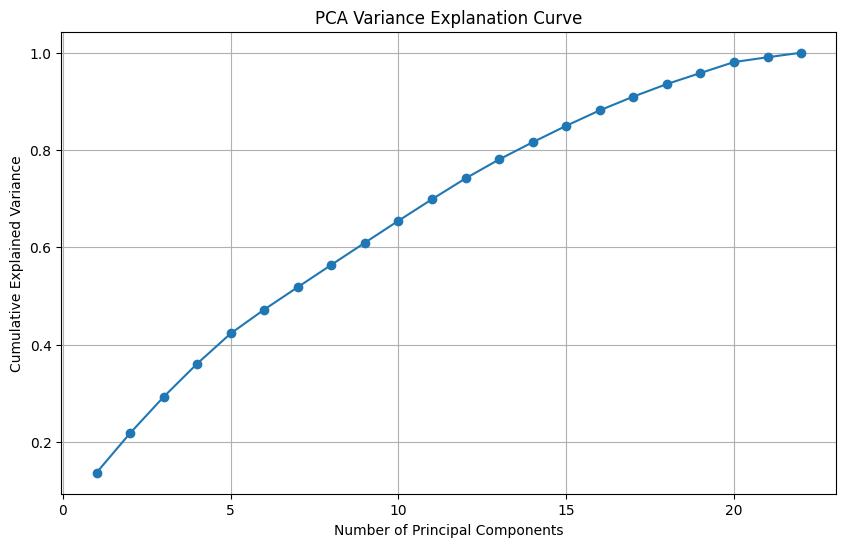

In [29]:
from sklearn.decomposition import PCA

# Assuming df_features_encoded is the dataset with categorical features encoded and missing values handled

# Initialize PCA
pca = PCA()

# Fit PCA to the dataset
pca.fit(df_features_scaled)

# Calculate cumulative explained variance
cumulative_variance = pca.explained_variance_ratio_.cumsum()

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Variance Explanation Curve')
plt.grid(True)
plt.show()

There isn't an obvious elbow we can choose for PCA, we will try t-SNE instead

## t-SNE

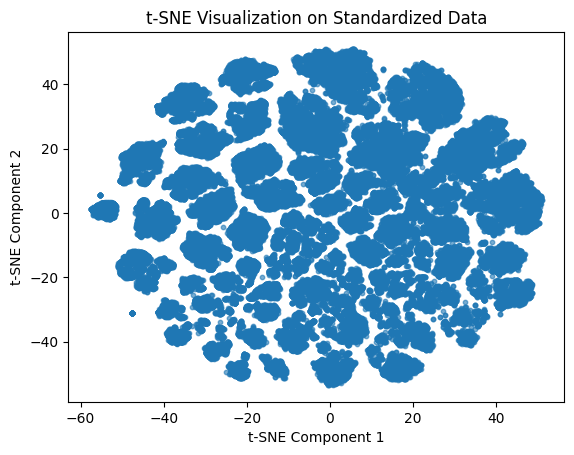

In [15]:
from sklearn.manifold import TSNE
# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
tsne_data = tsne.fit_transform(df_features_scaled)

# Plot the t-SNE results
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], s=10, alpha=0.6)
plt.title("t-SNE Visualization on Standardized Data")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

Since our dataset is quite large, ~80000 rows after dropping NA, we can try a bigger perplexity and see how

https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

"The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms. Larger datasets usually require a larger perplexity. Consider selecting a value between 5 and 50. Different values can result in significantly different results. The perplexity must be less than the number of samples."

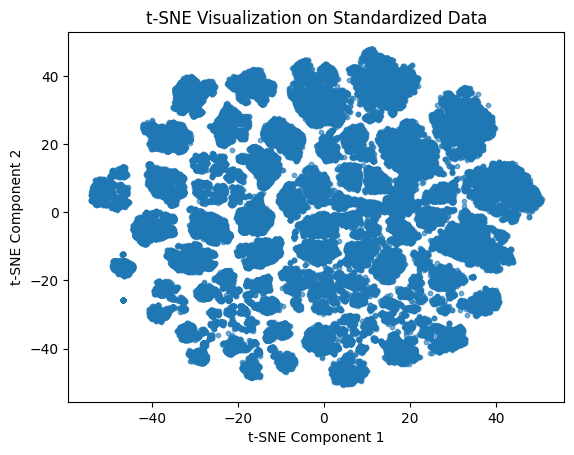

In [10]:
from sklearn.manifold import TSNE
# Apply t-SNE
tsne_2 = TSNE(n_components=2, random_state=42, perplexity=50, learning_rate=200)
tsne_data_2 = tsne_2.fit_transform(df_features_scaled)

# Plot the t-SNE results
plt.scatter(tsne_data_2[:, 0], tsne_data_2[:, 1], s=10, alpha=0.6)
plt.title("t-SNE Visualization on Standardized Data")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

Not that I don't want to fine-tune the perplexity hyperparameter, computational constraints

In [58]:
from sklearn.manifold import TSNE
from sklearn.manifold import trustworthiness

# Define a range of perplexity values to test
perplexity_values = [10, 20, 30, 40, 50]
trustworthiness_scores = []

# Calculate trustworthiness for each perplexity value
for perplexity in perplexity_values:
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    tsne_data = tsne.fit_transform(df_features_scaled)
    
    # Calculate trustworthiness between original and t-SNE reduced data
    trust_score = trustworthiness(df_features_scaled, tsne_data)
    trustworthiness_scores.append(trust_score)

# Plotting Trustworthiness vs Perplexity
plt.figure(figsize=(8, 5))
plt.plot(perplexity_values, trustworthiness_scores, marker='o', linestyle='-', color='b')
plt.xlabel("Perplexity")
plt.ylabel("Trustworthiness")
plt.title("Trustworthiness of t-SNE Projection vs. Perplexity")
plt.grid(True)
plt.show()


MemoryError: Unable to allocate 49.6 GiB for an array with shape (81577, 81577) and data type float64

## HDBSCAN

We will use HDBSCAN clustering algorithm and compare the silhoutte score to decide which t-SNE gave better clusters

https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html

https://scikit-learn.org/stable/auto_examples/cluster/plot_hdbscan.html#

https://www.geeksforgeeks.org/clustering-metrics/ 

Silhoutte Score: Better-defined clusters are indicated by higher scores, which range from -1 to 1. An object is said to be well-matched to its own cluster and poorly-matched to nearby clusters if its score is close to 1. A score of about -1, on the other hand, suggests that the object might be in the incorrect cluster.

Davies-Bouldin Index: It evaluates a dataset’s clusters’ compactness and separation. Better-defined clusters are indicated by a lower Davies-Bouldin Index, which is determined by comparing each cluster’s average similarity-to-dissimilarity ratio to that of its most similar neighbor.

we will pick the t-sne with higher silhoutte score and lower davies-bouldin index


Since the dataset has ~80000 rows, we will set the maximum points in a cluster to be 50000, to avoid situations where too high proportion of the data point is classified into 1 cluster, which makes the clustering not meaningful. 

### t-sne data 1

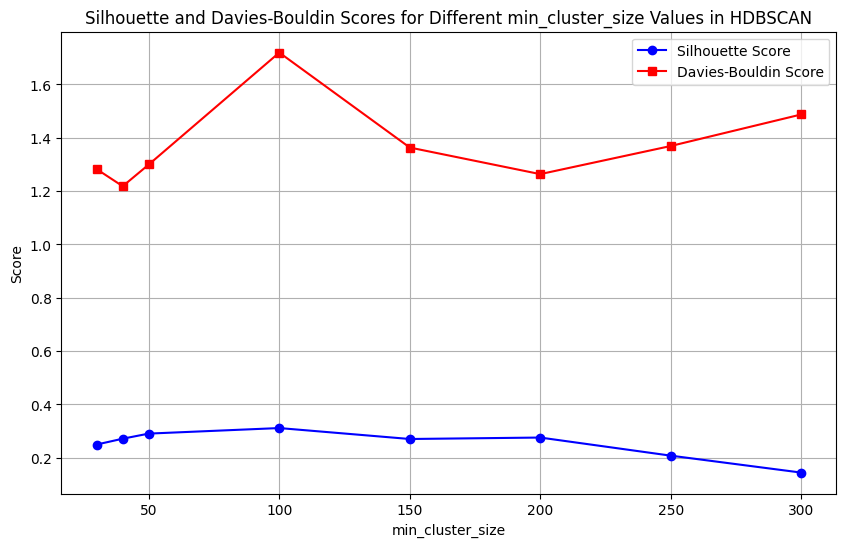

In [17]:
import hdbscan
from sklearn.metrics import silhouette_score, davies_bouldin_score
# Define a range of min_cluster_size values to test
min_cluster_sizes = [30, 40, 50, 100, 150, 200, 250, 300]
silhouette_scores = []  # List to store silhouette scores for each min_cluster_size
db_scores = []

for min_size in min_cluster_sizes:
    # Run HDBSCAN with the current min_cluster_size
    hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=min_size, max_cluster_size=50000)
    cluster_labels = hdbscan_clusterer.fit_predict(tsne_data)
    
    # Skip silhouette score calculation if all points are labeled as noise (-1)
    if len(set(cluster_labels)) <= 1:
        print(f"min_cluster_size {min_size}: Only noise, skipping silhouette score.")
        silhouette_scores.append(None)  # Append None for consistent plotting
        db_scores.append(None)
        continue
    
    # Calculate Silhouette Score
    silhouette_avg = silhouette_score(tsne_data, cluster_labels)
    db_score = davies_bouldin_score(tsne_data, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    db_scores.append(db_score)

# Plot Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(min_cluster_sizes, silhouette_scores, marker='o', color='b', label="Silhouette Score")
plt.plot(min_cluster_sizes, db_scores, marker='s', color='r', label="Davies-Bouldin Score")

# Labels and title
plt.xlabel("min_cluster_size")
plt.ylabel("Score")
plt.title("Silhouette and Davies-Bouldin Scores for Different min_cluster_size Values in HDBSCAN")
plt.legend()
plt.grid(True)
plt.show()

### t-sne data 2

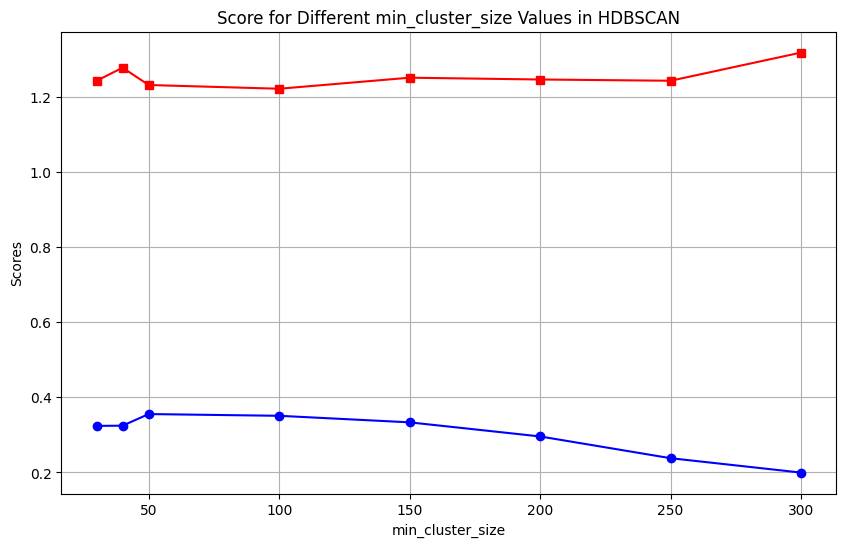

In [18]:
silhouette_scores_2 = []  # List to store silhouette scores for each min_cluster_size
db_scores_2 = []

for min_size in min_cluster_sizes:
    # Run HDBSCAN with the current min_cluster_size
    hdbscan_clusterer_2 = hdbscan.HDBSCAN(min_cluster_size=min_size, max_cluster_size=50000)
    cluster_labels_2 = hdbscan_clusterer_2.fit_predict(tsne_data_2)
    
    # Skip silhouette score calculation if all points are labeled as noise (-1)
    if len(set(cluster_labels_2)) <= 1:
        print(f"min_cluster_size {min_size}: Only noise, skipping silhouette score.")
        silhouette_scores_2.append(None)  # Append None for consistent plotting
        continue
    
    # Calculate Silhouette Score
    silhouette_avg = silhouette_score(tsne_data_2, cluster_labels_2)
    db_score = davies_bouldin_score(tsne_data_2, cluster_labels_2)
    silhouette_scores_2.append(silhouette_avg)
    db_scores_2.append(db_score)


# Plot Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(min_cluster_sizes, silhouette_scores_2, marker='o', color='b', label="Silhouette Score")
plt.plot(min_cluster_sizes, db_scores_2, marker='s', color='r', label="Davies-Bouldin Score")
plt.title("Score for Different min_cluster_size Values in HDBSCAN")
plt.xlabel("min_cluster_size")
plt.ylabel("Scores")
plt.grid(True)
plt.show()

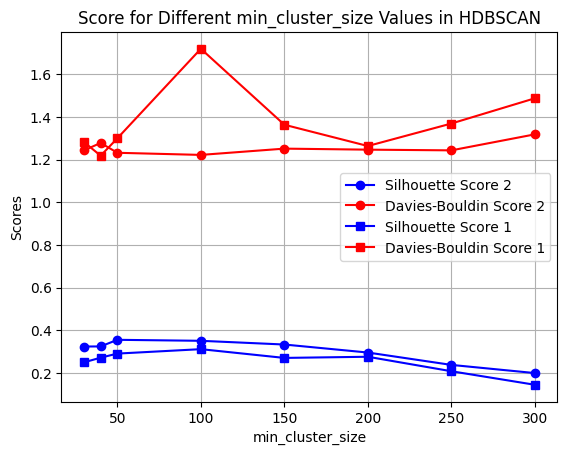

In [24]:
plt.plot(min_cluster_sizes, silhouette_scores_2, marker='o', color='b', label="Silhouette Score 2")
plt.plot(min_cluster_sizes, db_scores_2, marker='o', color='r', label="Davies-Bouldin Score 2")
plt.plot(min_cluster_sizes, silhouette_scores, marker='s', color='b', label="Silhouette Score 1")
plt.plot(min_cluster_sizes, db_scores, marker='s', color='r', label="Davies-Bouldin Score 1")
plt.title("Score for Different min_cluster_size Values in HDBSCAN")
plt.xlabel("min_cluster_size")
plt.ylabel("Scores")
plt.legend()
plt.grid(True)
plt.show()

In [29]:
pd.DataFrame([silhouette_scores, silhouette_scores_2, db_scores, db_scores_2])

,0,1,2,3,4,5,6,7
0,0.249505,0.271392,0.290530,0.311303,0.270261,0.275692,0.207832,0.144316
1,0.323617,0.324141,0.355128,0.350484,0.333045,0.295475,0.237509,0.199185
2,1.282334,1.218268,1.299777,1.719449,1.363359,1.263609,1.369036,1.487344
3,1.242957,1.278117,1.231908,1.221953,1.251377,1.246571,1.243248,1.318304


The Silhouette scores for the second t-SNE setup are generally higher across various values of `min_cluster_size` compared to the first t-SNE. The Davies Boulding Index is the secnond t-SNE set up is mostly lower than that of the first. 

The highest Silhouette Score for the second t-SNE is approximately 0.3551 at `min_cluster_size`=50, whereas the highest for the first t-SNE is around 0.3113 at `min_cluster_size`=100

Higher Silhouette Scores and lower Davies-Bouldin index generally indicate that clusters are better defined and more separated from each other. The results from the second t-SNE suggest that it may provide a more distinct clustering structure, which HDBSCAN is capturing effectively.

Therefore we will use the second t-SNE data for training our clustering models

## HDBSCAN model

We will go with the HDBSCAN model that gave the highest silhoutte score ie `min_cluster_size`=50


In [9]:
from sklearn.manifold import TSNE
# Apply t-SNE
tsne_2 = TSNE(n_components=2, random_state=42, perplexity=50, learning_rate=200)
tsne_data_2 = tsne_2.fit_transform(df_features_scaled)

In [ ]:
import hdbscan
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Run HDBSCAN on the t-SNE output
hdbscan_clusterer_2 = hdbscan.HDBSCAN(min_cluster_size=50, max_cluster_size=50000)
cluster_labels_2 = hdbscan_clusterer_2.fit_predict(tsne_data_2)


Silhouette Score on t-SNE with HDBSCAN: 0.35512787103652954


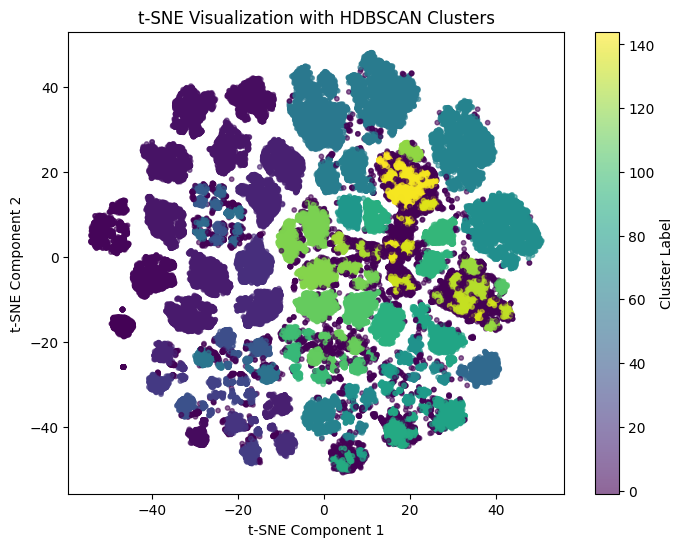

In [ ]:
db_score = davies_bouldin_score(tsne_data_2, cluster_labels_2)
silhouette_avg = silhouette_score(tsne_data_2, cluster_labels_2)
print(f"Silhouette Score on t-SNE with HDBSCAN: {silhouette_avg}")
print(f"Davies Bouldin Index on t-SNE with HDBSCAN: {db_score}")
# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(tsne_data_2[:, 0], tsne_data_2[:, 1], c=cluster_labels_2, cmap='viridis', s=10, alpha=0.6)
plt.colorbar(label='Cluster Label')
plt.title("t-SNE Visualization with HDBSCAN Clusters")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

In [69]:
print(np.sum(cluster_labels_2 == -1))
print(np.sum(cluster_labels_2 == -1)/len(tsne_data_2))

6354
0.0778896012356424


In [70]:
HDBCSAN_labels = cluster_labels_2

## KNN model

We will now build another model, KNN clustering model and compare the silhoutte score with HDBSCAN

https://www.geeksforgeeks.org/k-means-clustering-introduction/

https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

### fine tune k

In [30]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Assuming tsne_data_2 is your 2D array from t-SNE
X = tsne_data_2

# Define the range of clusters to test
range_n_clusters = range(15, 250, 10)

# List to store silhouette scores for each number of clusters
silhouette_scores = []
db_scores = []

# Loop over the range and compute silhouette scores
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)

    db_score = davies_bouldin_score(X, cluster_labels)
    db_scores.append(db_score)

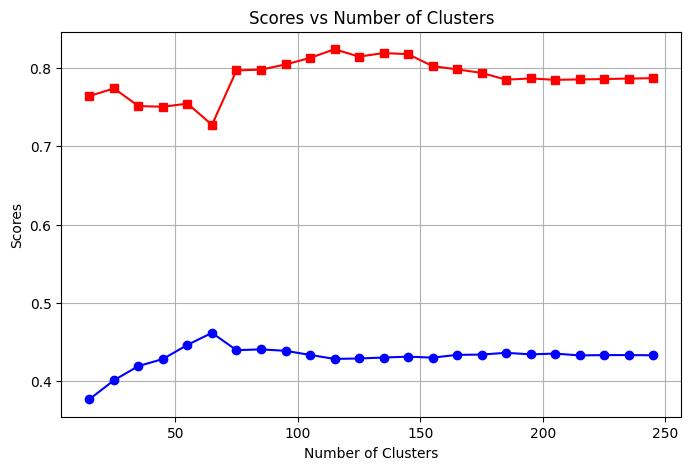

In [31]:
# Plotting the silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(range(15, 250, 10), silhouette_scores, marker='o', color='b', label="Silhouette Score")
plt.plot(range(15, 250, 10), db_scores, marker='s', color='r', label="Davies-Bouldin Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Scores")
plt.title("Scores vs Number of Clusters")
plt.grid(True)
plt.show()

We will get the k between 55 to 75 with the highest silhouttte score 

In [34]:
# List to store silhouette scores for each number of clusters
silhouette_scores_2 = []
db_scores_2=[]
# Loop over the range and compute silhouette scores
for n_clusters in range(56,75):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores_2.append(silhouette_avg)

    db_score = davies_bouldin_score(X, cluster_labels)
    db_scores_2.append(db_score)

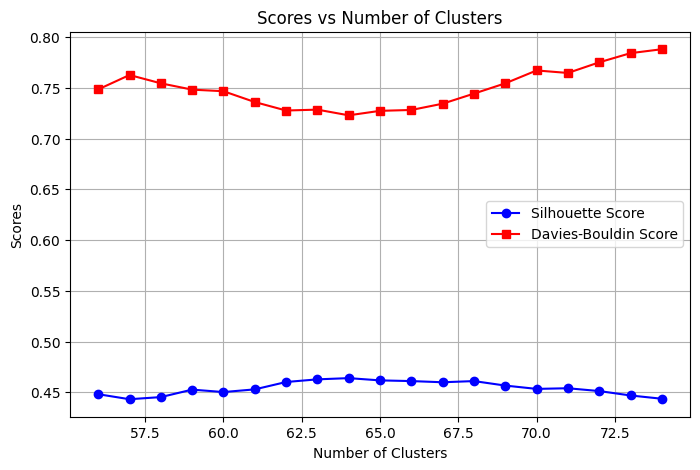

In [37]:
# Plotting the silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(range(56,75), silhouette_scores_2, marker='o', color='b', label="Silhouette Score")
plt.plot(range(56,75), db_scores_2, marker='s', color='r', label="Davies-Bouldin Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Scores")
plt.title("Scores vs Number of Clusters")
plt.grid(True)
plt.legend()
plt.show()

In [36]:
pd.DataFrame([silhouette_scores_2, db_scores_2])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.448065,0.443124,0.445224,0.452583,0.450185,0.452826,0.460090,0.462704,0.463908,0.461682,0.461000,0.459837,0.460999,0.456574,0.45330,0.453938,0.451163,0.446823,0.443587
1,0.748437,0.762617,0.754428,0.748193,0.746645,0.735973,0.727624,0.728492,0.722894,0.727312,0.728162,0.734347,0.744288,0.754412,0.76711,0.764627,0.775113,0.784152,0.788026


We will choose k = 64 since it gave the highest silhoutte score of 0.463908 and lowest davies bouldin index of 0.722894

### Model

In [10]:
from sklearn.cluster import KMeans
X = tsne_data_2
kmeans = KMeans(n_clusters=64, random_state=42)
cluster_labels = kmeans.fit_predict(X)

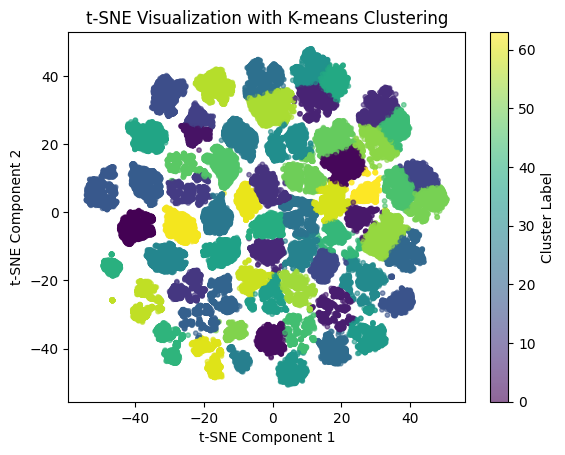

In [19]:
# Plot the clusters
plt.scatter(tsne_data_2[:, 0], tsne_data_2[:, 1], c=cluster_labels, cmap='viridis', s=10, alpha=0.6)
plt.colorbar(label='Cluster Label')
plt.title("t-SNE Visualization with K-means Clustering")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

silhouette_score(X,cluster_labels)
davies_bouldin_score(X,cluster_labels)

## might not want

In [15]:
import hdbscan

# Initialize HDBSCAN
hdbscan_clusterer = hdbscan.HDBSCAN()
cluster_labels = hdbscan_clusterer.fit_predict(df_pca_3d)
# Calculate and print Silhouette Score
silhouette_avg = silhouette_score(df_pca_3d, cluster_labels)
print(f"Silhouette Score with 3 PCA components: {silhouette_avg}")

Silhouette Score with 3 PCA components: 0.7880298862681387


In [ ]:
# Add cluster labels to the DataFrame for further analysis
df_clusters = pd.DataFrame(df_pca_3d, columns=['PCA_1', 'PCA_2', 'PCA_3'])
df_clusters['Cluster_Labels'] = cluster_labels

# Display the cluster label distribution
print(df_clusters['Cluster_Labels'].value_counts())

Cluster_Labels
 1    81571
 0        5
-1        1
Name: count, dtype: int64


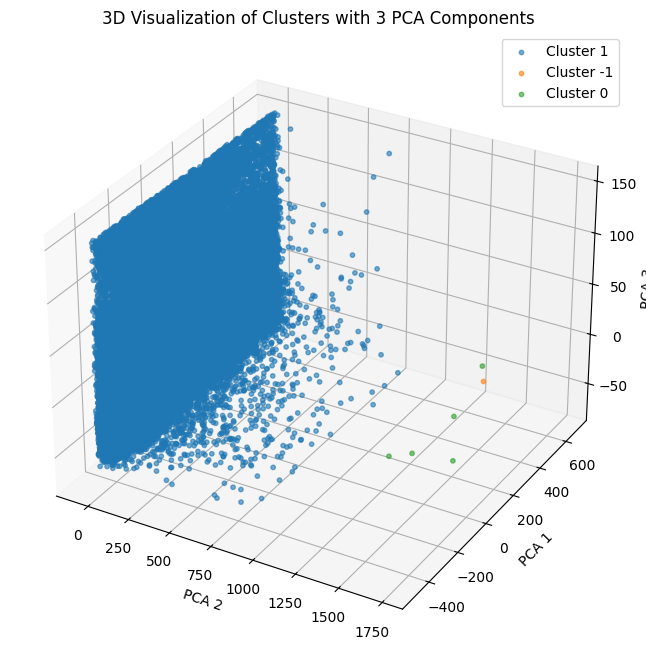

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Initialize a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each cluster with a unique color
unique_clusters = df_clusters['Cluster_Labels'].unique()

for cluster in unique_clusters:
    # Select data points that belong to the current cluster
    subset = df_clusters[df_clusters['Cluster_Labels'] == cluster]
    ax.scatter(subset['PCA_2'], subset['PCA_1'], subset['PCA_3'], 
               label=f'Cluster {cluster}', s=10, alpha=0.6)

# Set plot labels and title
ax.set_xlabel('PCA 2')
ax.set_ylabel('PCA 1')
ax.set_zlabel('PCA 3')
ax.set_title('3D Visualization of Clusters with 3 PCA Components')
ax.legend()

# Show the plot
plt.show()


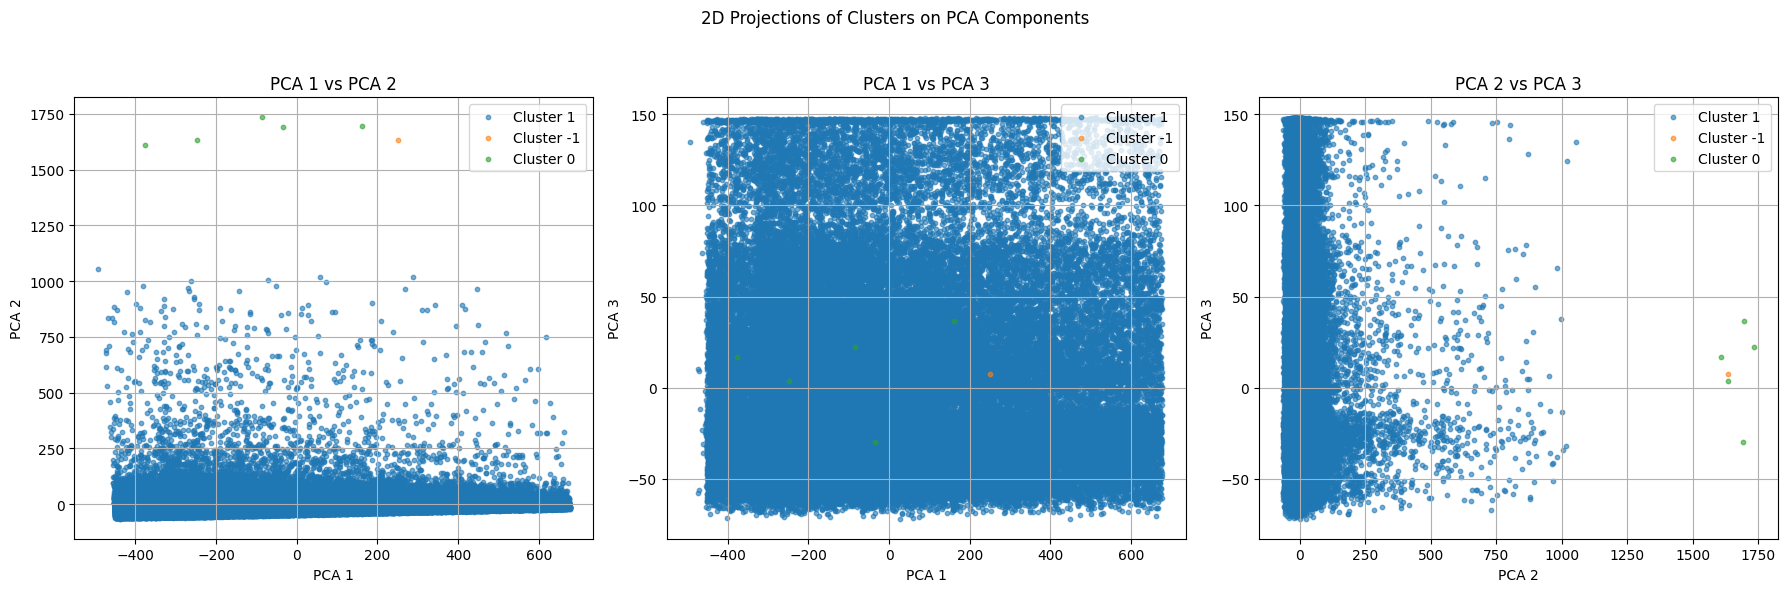

In [20]:
# Set up the figure with 3 subplots in 1 row
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Define color palette or use default for each cluster
unique_clusters = df_clusters['Cluster_Labels'].unique()
colors = plt.cm.tab10(range(len(unique_clusters)))  # You can adjust color map as needed

# Plot PCA 1 vs PCA 2
for cluster, color in zip(unique_clusters, colors):
    subset = df_clusters[df_clusters['Cluster_Labels'] == cluster]
    axes[0].scatter(subset['PCA_1'], subset['PCA_2'], s=10, alpha=0.6, label=f'Cluster {cluster}', color=color)
axes[0].set_xlabel('PCA 1')
axes[0].set_ylabel('PCA 2')
axes[0].set_title('PCA 1 vs PCA 2')

# Plot PCA 1 vs PCA 3
for cluster, color in zip(unique_clusters, colors):
    subset = df_clusters[df_clusters['Cluster_Labels'] == cluster]
    axes[1].scatter(subset['PCA_1'], subset['PCA_3'], s=10, alpha=0.6, label=f'Cluster {cluster}', color=color)
axes[1].set_xlabel('PCA 1')
axes[1].set_ylabel('PCA 3')
axes[1].set_title('PCA 1 vs PCA 3')

# Plot PCA 2 vs PCA 3
for cluster, color in zip(unique_clusters, colors):
    subset = df_clusters[df_clusters['Cluster_Labels'] == cluster]
    axes[2].scatter(subset['PCA_2'], subset['PCA_3'], s=10, alpha=0.6, label=f'Cluster {cluster}', color=color)
axes[2].set_xlabel('PCA 2')
axes[2].set_ylabel('PCA 3')
axes[2].set_title('PCA 2 vs PCA 3')

# Adjust layout and show legend in each plot
for ax in axes:
    ax.legend()
    ax.grid(True)

plt.suptitle("2D Projections of Clusters on PCA Components")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
hdbscan_clusterer = hdbscan.HDBSCAN()
cluster_labels = hdbscan_clusterer.fit_predict(df_pca_3d)
# Calculate and print Silhouette Score
silhouette_avg = silhouette_score(df_pca_3d, cluster_labels)
print(f"Silhouette Score with 3 PCA components: {silhouette_avg}")

Based on the graph, I think there should be more clusters, I am going to try UMAP instead of PCA. UMAP projects data based on local density and neighborhood preservation rather than the variance in each dimension.

nvm I keep having dependecy error for umap so i try t-SNE

In [23]:
import umap
import tqdm as notebook_tqdm
import hdbscan
from sklearn.metrics import silhouette_score

# Try UMAP with different numbers of dimensions
for n_components in [5, 10, 15]:
    umap_reducer = umap.UMAP(n_components=n_components, random_state=42)
    umap_data = umap_reducer.fit_transform(df_features_encoded)

    # Apply HDBSCAN on UMAP-reduced data
    hdbscan_clusterer = hdbscan.HDBSCAN()
    cluster_labels = hdbscan_clusterer.fit_predict(umap_data)

    # Calculate the silhouette score
    silhouette_avg = silhouette_score(umap_data, cluster_labels)
    print(f"Silhouette Score with {n_components} UMAP components: {silhouette_avg}")


OSError: [WinError 126] The specified module could not be found. Error loading "C:\Users\yipin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\lib\fbgemm.dll" or one of its dependencies.

Silhouette Score on t-SNE data: 0.07606321573257446


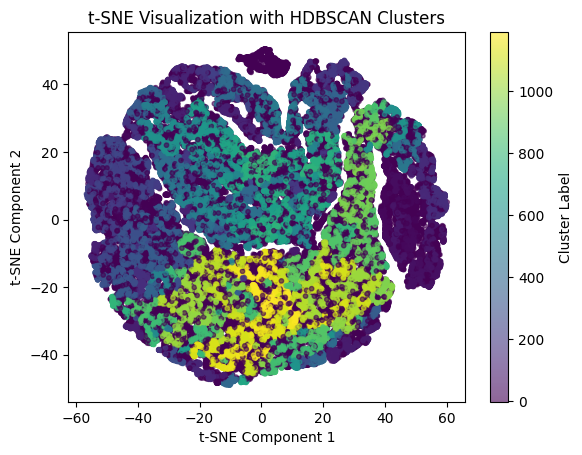

In [ ]:
from sklearn.manifold import TSNE
import hdbscan
from sklearn.metrics import silhouette_score

# Apply t-SNE for 2D projection
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
tsne_data = tsne.fit_transform(df_features_encoded)

Silhouette Score on t-SNE data: -0.048850953578948975


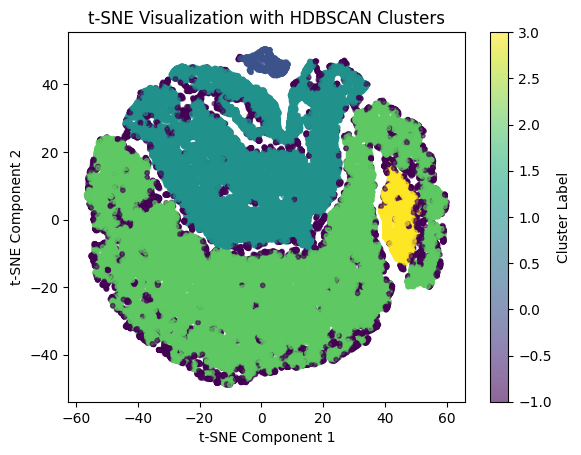

In [ ]:
# Run HDBSCAN on t-SNE-transformed data
hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=100, max_cluster_size=50000, metric='euclidean')
cluster_labels = hdbscan_clusterer.fit_predict(tsne_data)

# Calculate Silhouette Score to evaluate clustering on t-SNE data
silhouette_avg = silhouette_score(tsne_data, cluster_labels)
print(f"Silhouette Score on t-SNE data: {silhouette_avg}")

# Visualize clusters if using 2D t-SNE
import matplotlib.pyplot as plt
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=cluster_labels, cmap='viridis', s=10, alpha=0.6)
plt.colorbar(label='Cluster Label')
plt.title("t-SNE Visualization with HDBSCAN Clusters")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

Silhouette Score on t-SNE data: -0.048850953578948975


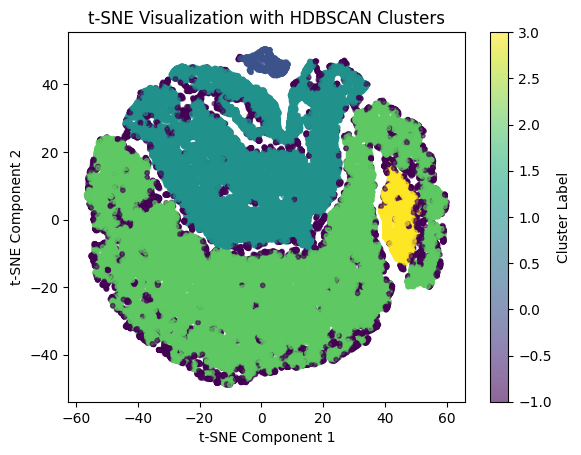

In [28]:
# Run HDBSCAN on t-SNE-transformed data
hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=100, max_cluster_size=50000, metric='euclidean', alpha=0.8)
cluster_labels = hdbscan_clusterer.fit_predict(tsne_data)

# Calculate Silhouette Score to evaluate clustering on t-SNE data
silhouette_avg = silhouette_score(tsne_data, cluster_labels)
print(f"Silhouette Score on t-SNE data: {silhouette_avg}")

# Visualize clusters if using 2D t-SNE
import matplotlib.pyplot as plt
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=cluster_labels, cmap='viridis', s=10, alpha=0.6)
plt.colorbar(label='Cluster Label')
plt.title("t-SNE Visualization with HDBSCAN Clusters")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

In [27]:
from sklearn.metrics import davies_bouldin_score

davies_bouldin = davies_bouldin_score(tsne_data, cluster_labels)
print(f"Davies-Bouldin Score on t-SNE data: {davies_bouldin}")

Davies-Bouldin Score on t-SNE data: 3.91475041636714


In [11]:
import hdbscan

# Initialize HDBSCAN with a minimum cluster size (adjust as needed)
hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=3, metric='euclidean')

# Fit HDBSCAN to the encoded dataset and obtain cluster labels
cluster_labels = hdbscan_clusterer.fit_predict(df_features_scaled)

# Add cluster labels to the original dataset for easy reference
df['Cluster_Labels'] = cluster_labels

# Display the dataset with cluster labels added
print(df.head())

# Optional: Display the cluster count to understand distribution
print(df['Cluster_Labels'].value_counts())


   CustomerID  Age  Gender Payment Method  Churn  Tenure  HourSpendOnApp  \
1           1   17  Female           Cash      0    28.0             2.0   
2           2   42  Female           Cash      0    15.0             2.0   
3           3   37  Female           Cash      1     1.0             0.0   
5           5   31  Female           Cash      0     4.0             2.0   
6           6   63  Female           Cash      1     1.0             4.0   

   NumberOfDeviceRegistered  SatisfactionScore  CouponUsed  ...  ordered  \
1                         4                  2         3.0  ...        2   
2                         3                  4         0.0  ...        2   
3                         3                  4         0.0  ...        2   
5                         5                  3         0.0  ...        2   
6                         4                  5         8.0  ...        1   

   total_order  ave_monthly_orders  days_last_order  returned  \
1            2       

In [23]:
# Count total points and those classified as noise (label -1)
total_points = len(df)
noise_points = (df['Cluster_Labels'] == -1).sum()

# Calculate the percentage of noise points
noise_percentage = (noise_points / total_points) * 100
print(f"Percentage of unclassified (noise) points: {noise_percentage:.2f}%")


Percentage of unclassified (noise) points: 2.49%


Calculate the silhouette_score

In [24]:
from sklearn.metrics import silhouette_score

# Calculate silhouette score using the original high-dimensional space or the encoded features
silhouette_avg = silhouette_score(df_features_encoded, df['Cluster_Labels'])
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: -0.5671209879394653


When I did not scale, the score was 0.8

IF standard scaler, the score was -0.3

if min-max scaling, the score was -0.5

But not doing feature standardisation doesn't make sense if the distance metrics is euclidian, we will try cosine 

err cosine not working what is going on

In [27]:
# Drop 'CustomerID' as it is a unique identifier and not a feature for clustering
df_features = df.drop(columns=['CustomerID'])

# Convert categorical columns to numerical format
categorical_columns = df_features.select_dtypes(include=['object']).columns
df_features_encoded = pd.get_dummies(df_features, columns=categorical_columns, drop_first=True)


# Initialize HDBSCAN with a minimum cluster size (adjust as needed)
hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=3, metric='cosine')

# Fit HDBSCAN to the encoded dataset and obtain cluster labels
cluster_labels = hdbscan_clusterer.fit_predict(df_features_scaled)

# Add cluster labels to the original dataset for easy reference
df['Cluster_Labels'] = cluster_labels

# Optional: Display the cluster count to understand distribution
print(df['Cluster_Labels'].value_counts())

ValueError: Unrecognized metric 'cosine'

# Understand the clusters
Explain the clusterings

In [15]:
# Plot the condensed tree for hierarchical structure
plt.figure(figsize=(10, 8))
hdbscan_clusterer.condensed_tree_.plot(select_clusters=True, label_clusters=True, colorbar=True)
plt.title("HDBSCAN Condensed Tree - Hierarchical Structure")
plt.xlabel("Points within clusters")
plt.ylabel("Cluster hierarchy")
plt.show()

NameError: name 'hdbscan_clusterer' is not defined

<Figure size 1000x800 with 0 Axes>

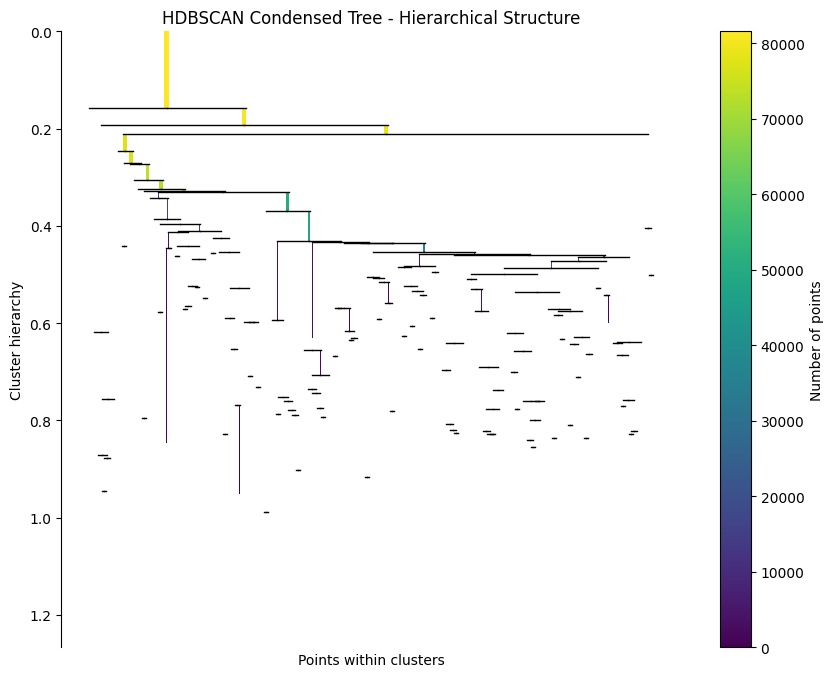

In [ ]:
# Plot the condensed tree for hierarchical structure
plt.figure(figsize=(10, 8))
hdbscan_clusterer.condensed_tree_.plot()
plt.title("HDBSCAN Condensed Tree - Hierarchical Structure")
plt.xlabel("Points within clusters")
plt.ylabel("Cluster hierarchy")
plt.show()

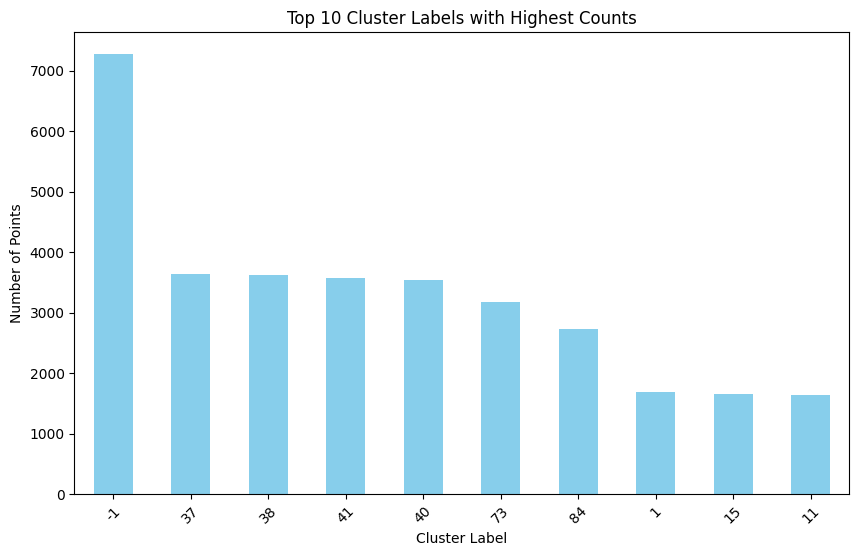

In [ ]:
# Count occurrences of each label
label_counts = pd.Series(cluster_labels_2).value_counts()

# Get the top 10 labels with the highest counts
top_10_labels = label_counts.head(10)

# Plot a histogram of the top 10 labels
plt.figure(figsize=(10, 6))
top_10_labels.plot(kind='bar', color='skyblue')
plt.title("Top 10 Cluster Labels with Highest Counts")
plt.xlabel("Cluster Label")
plt.ylabel("Number of Points")
plt.xticks(rotation=45)
plt.show()

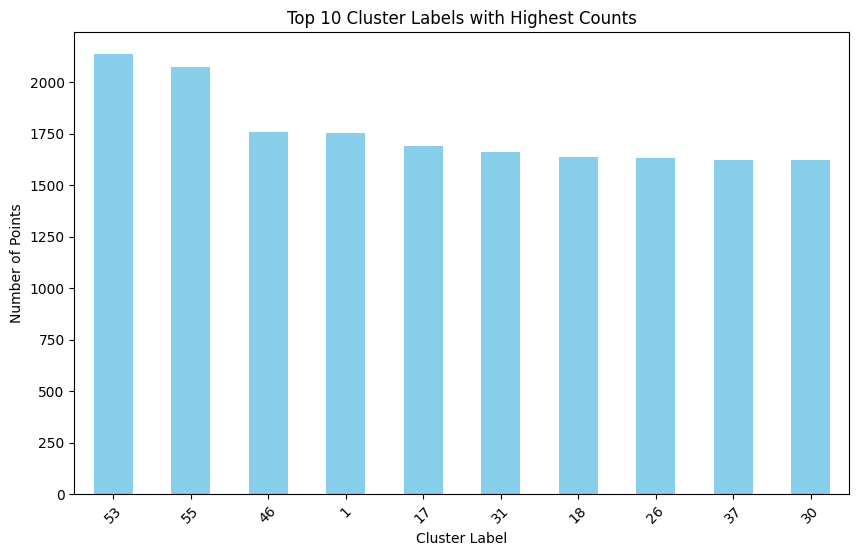

In [20]:
# Count occurrences of each label
label_counts = pd.Series(cluster_labels).value_counts()

# Get the top 10 labels with the highest counts
top_10_labels = label_counts.head(10)

# Plot a histogram of the top 10 labels
plt.figure(figsize=(10, 6))
top_10_labels.plot(kind='bar', color='skyblue')
plt.title("Top 10 Cluster Labels with Highest Counts")
plt.xlabel("Cluster Label")
plt.ylabel("Number of Points")
plt.xticks(rotation=45)
plt.show()

In [ ]:
df['Cluster_Label'] = cluster_labels_2